In [1]:
%%capture
#!pip install tifffile
#!pip install zarr
#!pip install matplotlib
#!pip install imagecodecs
#!pip install opencv-python
#!pip install scikit-image

In [2]:
import tifffile
import zarr
import matplotlib.pyplot as plt
import numpy as np

from raw_data_parser import raw_data_parser
from circle_colors_lib import circle_colors
from colour.models import RGB_COLOURSPACE_sRGB, RGB_to_XYZ, XYZ_to_RGB
from colour.utilities import tstack, as_float_array
from PIL import Image

Это попытка реализовать нормальный корректор с помощью метода наименьших квадратов

In [3]:
def color_correction_matrix(measured, target):
    """
    Находит матрицу преобразования для цветовой коррекции.
    
    :param measured: Измеренные значения цветов
    :param target: Целевые значения цветов
    :return: Матрица преобразования
    """
    A = np.vstack([measured.T, np.ones(len(measured))]).T
    m, _, _, _ = np.linalg.lstsq(A, target, rcond=None)
    return m.T

def apply_color_correction(image, correction_matrix):
    """
    Применяет цветовую коррекцию к изображению с использованием матрицы преобразования.
    
    :param image: Изображение для коррекции
    :param correction_matrix: Матрица преобразования
    :return: Скорректированное изображение
    """
    shape = image.shape
    image_reshaped = image.reshape((-1, 3))
    corrected_image_reshaped = np.dot(image_reshaped, correction_matrix[:, :3].T) + correction_matrix[:, 3]
    corrected_image = corrected_image_reshaped.reshape(shape)
    return np.clip(corrected_image, 0, 1)

In [4]:
rw = raw_data_parser()
circ = circle_colors()
# Истинные значения RGB для каждого кружка в палетке (пример)
true_values = rw.get_reference_srgbs()

# Загрузим фотографию палетки
store = tifffile.imread('./Calib_Polaris_Scan3.qptiff', aszarr=True)
zarr_pyramids = zarr.open(store, mode='r')
palette_image = np.array(zarr_pyramids[6]) / 255.0  # Нормализуем значения до [0, 1]

In [5]:
# Преобразуем изображение в линейное пространство sRGB
linear_palette_image = RGB_to_XYZ(palette_image, RGB_COLOURSPACE_sRGB)

# Извлекаем RGB значения из изображения
palette_values = np.array([
    [0.790717285372828,	0.801256401914597,	0.796338432711342],
    [0,	0.350940776870057,	0.526414136862033],
    [0.473224991536591,	0.152290793758534,	0.148831287466144],
    [0.52020109023946,	0.226439668548603,	0.381334032788723],
    [0.163842554764071,	0.402002829381901,	0.253736782112475],
    [0.862753125364638,	0.539651854557734,	0],
    [0,	0.192496678847772,	0.385475052853889],
    [0.19583620843781,	0.191881443743256,	0.276248542336396],
    [0.76952835145523,	0.772165441698664,	0.770506465665032],
    [0.604355213553106,	0.642844748647336,	0.653419953932636],
    [0.454946943815544,	0.509915557538826,	0.52347479195776],
    [0.537829070734749,	0.211441442336174,	0.238431000510607],
    [0.689989678354408,	0.32101463729849,	0.125444030232391],
    [0.775621993838981,	0.454132282671633,	0.0993028851421258],
    [0.533021954649746,	0.531122850452711,	0.201774406207444],
    [0.300410110496789,	0.354977049569712,	0.371370654798425],
    [0.190667527300917,	0.234256632301206,	0.246955643273608],
    [0.120697307001674,	0.147982084499963,	0.154634569558384],
    [0.0359352114262377,	0.256182847463534,	0.470967304628066],
    [0.131204341923757,	0.568779825007793,	0.582754245273572],
    [0.296612479902438,	0.390485874284752,	0.53782607551024],
    [0.240147671604541,	0.29772528136622,	0.216121960577454],
    [0.141254350043775,	0.354837326686926,	0.477234187195753],
    [0.605482332825879,	0.430899208961207,	0.369376509336982],
    [0.297430746586519,	0.225652960022101,	0.19926212765972],
])

#i = 1
#j = 1
#true_values[6*i+j]
#palette_values[6*i+j]

In [6]:
circ.calculate_delta_E(true_values,palette_values)

array([[  2.15616874],
       [ 21.59146565],
       [ 58.38917201],
       [ 29.27491117],
       [ 60.01284019],
       [ 16.20699248],
       [ 11.23052216],
       [ 21.5624528 ],
       [  2.20664391],
       [  3.71219886],
       [  5.80552272],
       [ 23.65157921],
       [ 45.24043007],
       [ 70.53042576],
       [ 25.2018534 ],
       [  7.97464406],
       [  7.44852007],
       [  2.79681923],
       [ 65.91233641],
       [ 52.88928789],
       [ 17.86598761],
       [ 10.84951834],
       [ 15.58955975],
       [  4.8131285 ],
       [ 10.78516683]])

In [7]:

# Находим матрицу преобразования
correction_matrix = color_correction_matrix(palette_values, true_values)

# Применяем цветовую коррекцию
corrected_palette = apply_color_correction(as_float_array(linear_palette_image), correction_matrix)

# Преобразуем обратно в sRGB
corrected_palette = XYZ_to_RGB(corrected_palette.reshape(linear_palette_image.shape), RGB_COLOURSPACE_sRGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


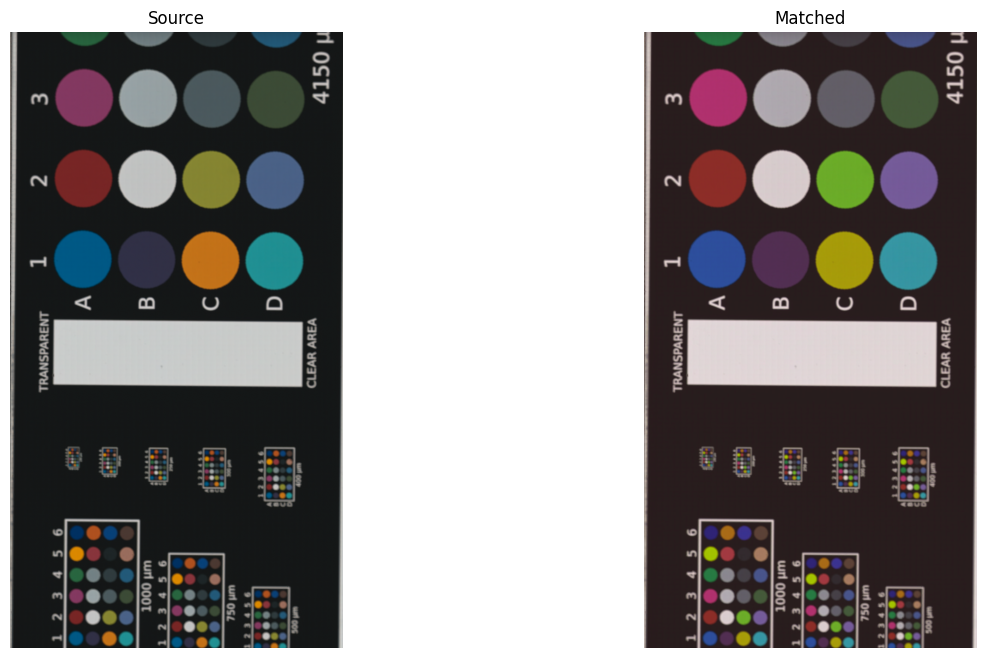

In [8]:
# Отображаем исходное и скорректированное изображение
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), sharex=True, sharey=True)
for aa in (ax1, ax2):
    aa.set_axis_off()

ax1.imshow(palette_image)
ax1.set_title('Source')
ax2.imshow(corrected_palette)
ax2.set_title('Matched')
corrected_palette_clipped = np.clip(corrected_palette * 255, 0, 255).astype(np.uint8)
tif = Image.fromarray(corrected_palette_clipped)
tif.save("./LSprocessedPolaris.tif")

In [9]:
palette_values.shape

(25, 3)